## Case study: Racine's early and late tragedies [#fn_authors]_
==============================================================

This tutorial describes two stages of an analysis of a collection of French
tragedies: (1) exploratory data analysis and (2) a closer quantitative reading
of an aspect of interest in the corpus: `Jean Racine's
<https://en.wikipedia.org/wiki/Jean_Racine>`_ early and late plays.

### Corpus: sixty tragedies
=======================

The corpus being explored is a collection of 60 French tragedies gathered from
Paul FiÃ¨vre's `â€žThÃ©Ã¢tre classiqueâ€ collection of French seventeenth and
eighteenth-century plays <http://www.theatre-classique.fr>`_ (available in
:ref:`datasets`).

Following the maxim "know your data", we first want to gain a rough sense of the
length (in words) of the texts in a corpus. Are we dealing with 100,000 word
tomes or 1,000 word newspaper articles? Even though we know we are dealing with
French tragedies inspecting text lengths is always worthwhile. For example,
checking the length of the texts in a corpus is an easy way to spot problems
such as incomplete texts. In the present case, we might also consider checking
the number of lines (`alexandrines
<https://en.wikipedia.org/wiki/Alexandrine>`_) as this is the standard measure
for compositions in verse.  Regardless of what unit is used, the easiest way
to visualize the distribution of lengths in a corpus is a histogram. In
order to create a histogram we need first to calculate the length of all the
texts in our corpus. If we have a document-term matrix available, the length in
words may be calculated by summing the rows of the document-term matrix, as each
row corresponds to one document.


In [1]:

import os
import numpy as np
import sklearn.feature_extraction.text as text

data_dir = 'data/french-tragedy/'

filenames = np.array(sorted(os.listdir(data_dir)))
filenames_with_path = [os.path.join(data_dir, fn) for fn in filenames]

# check the first few filenames
filenames_with_path[0:4]

vectorizer = text.CountVectorizer(input='filename')
dtm = vectorizer.fit_transform(filenames_with_path)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

# sum over rows to calculate lengths
lengths = np.sum(dtm, axis=1)



Now that we have the texts' lengths stored in the array ``lengths`` we can
create a histogram with the matplotlib function ``hist``.


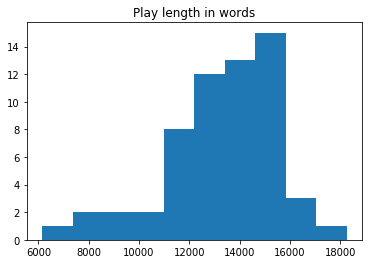

(6150, 'Voltaire_TR-V-1751-DucDAlencon.txt')

In [3]:

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.savefig('plots/9_case_study_voltaire_hist.png', bbox_inches='tight')
plt.title("Play length in words")
plt.show()

# find the longest and the shortest texts
(np.max(lengths), filenames[np.argmax(lengths)])
(np.min(lengths), filenames[np.argmin(lengths)])

Turning to the contents of the corpus, one way to explore a collection is to
plot the distances between texts. We have already seen how to do this in
:ref:`working-with-text`. As we have not normalized our texts by play
length---and the histogram of lengths shows us that there is considerable
variation---cosine distance is an appropriate choice for a measure of distance.


In [6]:

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
dist = 1 - cosine_similarity(dtm)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# create very short names for plotting
# filenames have form: Voltaire_TR-V-1724-Mariamne.txt
names = []
authors = []
for fn in filenames:
    author = fn.split('_')[0]
    year = fn.split('-')[2]
    authors.append(author)
    names.append(author + year)



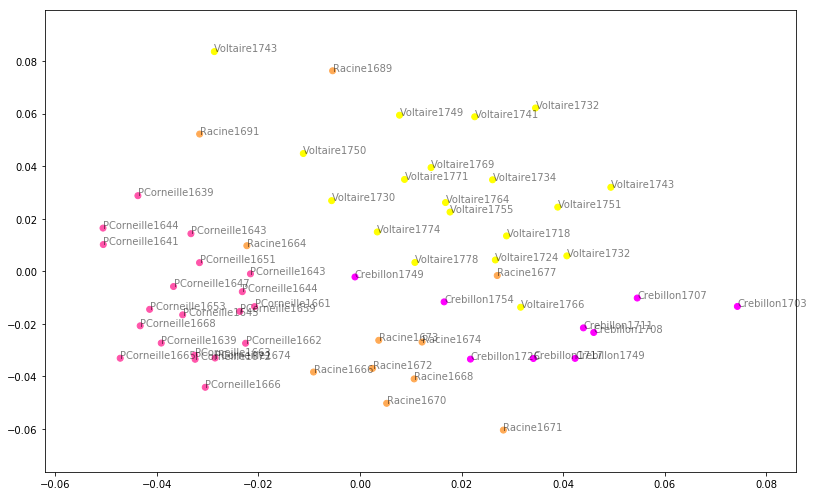

In [13]:

plt.figure(figsize=(11.3, 7))  # use a bigger canvas than usual
xs, ys = pos[:, 0], pos[:, 1]

authors_unique = sorted(set(authors))
colors = [authors_unique.index(a) for a in authors]
plt.scatter(xs, ys, c=colors, cmap='spring')
for x, y, name in zip(xs, ys, names):
    plt.text(x, y, name, alpha=0.5, fontsize=10)

plt.savefig('plots/9_voltaire_mds.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


This kind of plot can get overwhelming. A dendrogram plot offers an alternative
means of representing the same information (i.e., the distance between texts).
It is important, however, not to take the implied hierarchy too seriously.
While two texts paired together in the dendrogram are indeed nearest neighbors
in terms of distance, there are a variety of methods of hierarchical clustering
each often yielding different hierarchies. Right now we are interested in the
dendrogram as a convenient summary of the multi-dimensional scaling plot shown
above.


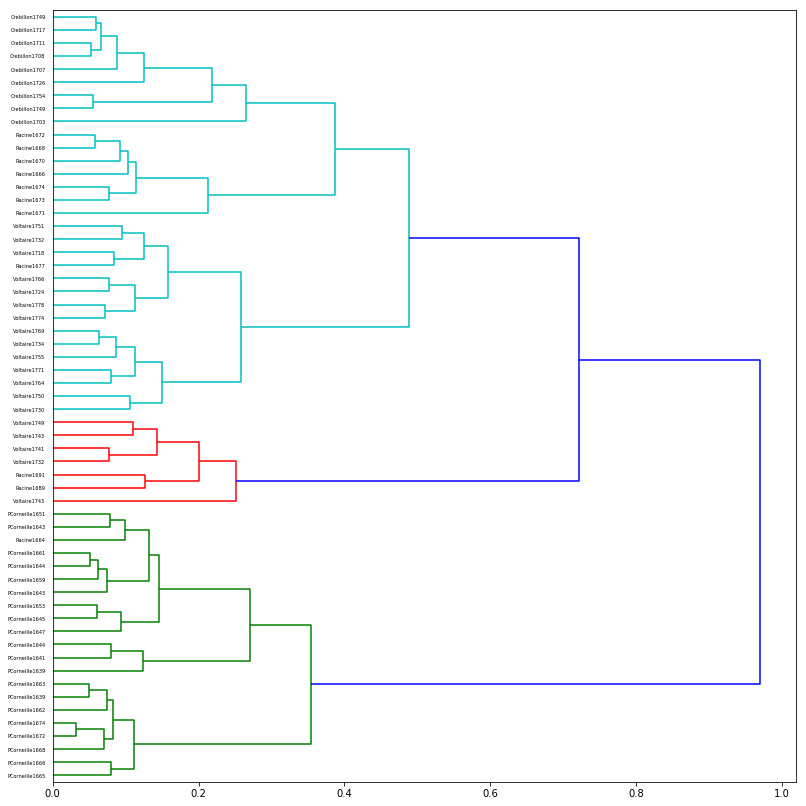

In [15]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

plt.figure(figsize=(11.3, 11.3))  # we need a tall figure
# match dendrogram to that returned by R's hclust()
dendrogram(linkage_matrix, orientation="right", labels=names, leaf_font_size=5);
plt.savefig('plots/9_voltaire_mds.png', bbox_inches='tight')
plt.tight_layout()  # fixes margins
plt.show()

It should come as no surprise that texts by the same author tend to be adjacent
in the dendrogram. It is well documented that authors frequently leave stylistic
"signatures" that are detectable at the level of word frequency. [#fn_authorship_attribution]_
There are, however, a number of plays that do not follow the rule and are paired
with texts by other writers. A number of these plays are attributed to Racine
and it is to these plays we will turn our attention.

### Racine's atypical plays
=======================

Racine's atypical plays are easiest to detect on the dendrogram. They include:

- `La ThÃ©baÃ¯de <https://fr.wikipedia.org/wiki/La_Th%C3%A9ba%C3%AFde_%28Racine%29>`_ (1664)
- `PhÃ¨dre <https://fr.wikipedia.org/wiki/Ph%C3%A8dre_(Racine)>`_ (1677)
- `Esther <https://fr.wikipedia.org/wiki/Esther_(Racine)>`_ (1689)
- `Athalie <https://fr.wikipedia.org/wiki/Athalie_(Racine)>`_ (1691)

Considering these outliers in the context of the chronology of Racine's works as
a whole is helpful. These plays include the first and the final three plays
written by Racine. To display this chronology visually we may use a raster
graph, coloring the outliers a distinct color. (This visualization has the added
benefit of showing the nearly ten year gap between plays in the 1680s.)



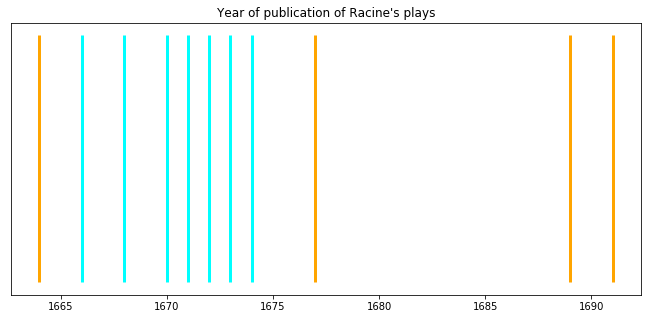

In [14]:
plt.figure(figsize=(11.3, 5))  # reset figure size

outliers = [1664, 1677, 1689, 1691]
racine_years = []
for fn in filenames:
    author = fn.split('_')[0]
    year = int(fn.split('-')[2])
    if author == "Racine":
        racine_years.append(year)
racine_years = np.array(racine_years)
colors = []
for year in racine_years:
    colors.append('orange' if year in outliers else 'cyan')
plt.vlines(racine_years, 0, 1, linewidth=3, color=colors)

plt.title("Year of publication of Racine's plays")
# gca() stands for get current axes. Axes are a matplotlib primitive.
# See http://matplotlib.org/users/pyplot_tutorial.html#working-with-multiple-figures-and-axes 
ax = plt.gca()
plt.savefig('plots/9_racine_voltaire_rastergram.png', bbox_inches='tight')
ax.yaxis.set_visible(False)
plt.show()


A provisional explanation for why the late plays stand out might draw on
Racine's religious turn. In 1679 he married Catherine de
Romanet and his `Jansenism <https://en.wikipedia.org/wiki/Jansenism>`_ grew more
pronounced. The title *Esther* refers to the biblical book of the same name and
*Athalie*, Racine's final play, stages events from the Bible.

### Features
--------

A useful way to explore the atypical plays further is to directly compare the
outliers with a fictitious "average" Racine tragedy. To do this we will first
decompose our documents into an ersatz "topic model" using non-negative matrix
factorization and then we will average the topic shares of the "normal" Racine
plays and compare those shares with the shares of the atypical plays.

We will fit the NMF model using the corpus of tragedies split into approximately
1,000-word sections. Recall that before feeding your document-term matrix into
NMF it is helpful to normalize each document by length. Here we will
normalize and, additionally, use tf-idf weighting as the invocation is simple:
we use ``TfidfVectorizer`` instead of ``CountVectorizer``.



In [18]:

data_dir = 'data/french-tragedy-split/'

filenames = np.array(sorted(os.listdir(data_dir)))
filenames_with_path = [os.path.join(data_dir, fn) for fn in filenames]

# check the first few filenames
filenames_with_path[0:4]

vectorizer = text.TfidfVectorizer(input='filename', min_df=15)
dtm = vectorizer.fit_transform(filenames_with_path)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())


In [19]:
# fit NMF model

from sklearn import decomposition

num_topics = 15

clf = decomposition.NMF(n_components=num_topics, random_state=1)

# this next step may take some time



In [20]:
import os
import pickle

NMF_TOPICS = 'source/cache/nmf-racine-doc-topic-{}topics.pkl'.format(num_topics)
NMF_CLF = 'source/cache/nmf-racine-clf-{}topics.pkl'.format(num_topics)

# the ipython directive seems to have trouble with multi-line indented blocks
if not os.path.exists(NMF_CLF):
    doctopic_chunks = clf.fit_transform(dtm)
    pickle.dump(doctopic_chunks, open(NMF_TOPICS, 'wb'))
    pickle.dump(clf, open(NMF_CLF, 'wb'))

clf = pickle.load(open(NMF_CLF, 'rb'))
doctopic_chunks = pickle.load(open(NMF_TOPICS, 'rb'))



In [21]:
doctopic_chunks = clf.fit_transform(dtm)


In order to interpret and visualize the NMF components in a manner analogous to
LDA topic proportions, we will scale the document-component matrix such that
the component values associated with each document sum to one.


In [23]:
# to avoid division by 0 (not a problem with LDA) we add a tiny value to each cell.
doctopic_chunks += 1e-6  # 1e-6 is the same as 0.000001
doctopic_chunks = doctopic_chunks / np.sum(doctopic_chunks, axis=1, keepdims=True)    

As we did in :ref:`previous sections <topic-model-mallet>`, we will aggregate
the text sections associated with a single play together and average their topic
proportions.


In [26]:

import itertools
import re
import operator

# Play sections have filenames like: Racine_TR-V-1677-Phedre0000.txt. We can split 
# the last part "0000.txt" off using string slicing since we know that the part of
# the filename we do not want is always 8 characters in width. For example,
'Racine_TR-V-1677-Phedre0000.txt'[:-8]
# alternatively, we could use a regular expression:
import re
re.sub(r'[0-9]+\.txt$','', 'Racine_TR-V-1677-Phedre0000.txt')

play_names_chunks = []
for fn in filenames:
    play_names_chunks.append(fn[:-8])

num_plays = len(set(play_names_chunks))
doctopic = np.zeros((num_plays, num_topics))
play_row_pairs = zip(play_names_chunks, doctopic_chunks)
play_names = []
for i, (name, pairs) in enumerate(itertools.groupby(play_row_pairs, key=operator.itemgetter(0))):
    rows = [row for _, row in pairs]
    doctopic[i, :] = sum(rows) / len(rows)
    play_names.append(name)


While we have used all the other plays to fit the NMF model---in deriving the
topic components and the word-topic associations---we care principally about
Racine's atypical plays and the synthetic "average" play that will serve as a proxy for
a "normal" Racine play. We will construct the average play by averaging the
shares of the typical plays (i.e., all those that are not atypical):


In [28]:
racine_plays = [name for name in play_names if name.startswith('Racine')]
racine_atypical = ['Racine_TR-V-1664-Thebaide', 'Racine_TR-V-1677-Phedre', 'Racine_TR-V-1689-Esther', 'Racine_TR-V-1691-Athalie']
racine_typical = [name for name in racine_plays if name not in racine_atypical]
# alternatively, an opportunity to use set difference
# racine_typical = list(set(racine_plays) - set(racine_atypical))

# examine the list of typical plays, making sure we have the right ones
racine_typical

doctopic_racine_typical = np.mean(doctopic[np.in1d(play_names, racine_typical)], axis=0)
doctopic_racine_atypical = doctopic[np.in1d(play_names, racine_atypical)]

# stack the typical and the atypical plays by row
doctopic_of_interest = np.row_stack([doctopic_racine_typical, doctopic_racine_atypical])

# as a last and final step we need to keep track of the names
# note that some of the manipulation of names and rows is fragile and relies on the names
# being sorted alphabetically. If this were a concern we might use a pandas DataFrame
# instead, as row and column names can be explicitly assigned
play_names_of_interest = ['Racine-1666-1674-AVERAGE'] + racine_atypical

Now that we have our matrix of document-topic proportions for the atypical plays
and the composite Racine play, we can visualize the topic shares using
a heatmap, a procedure which should be familiar from
:ref:`topic-model-visualization`.


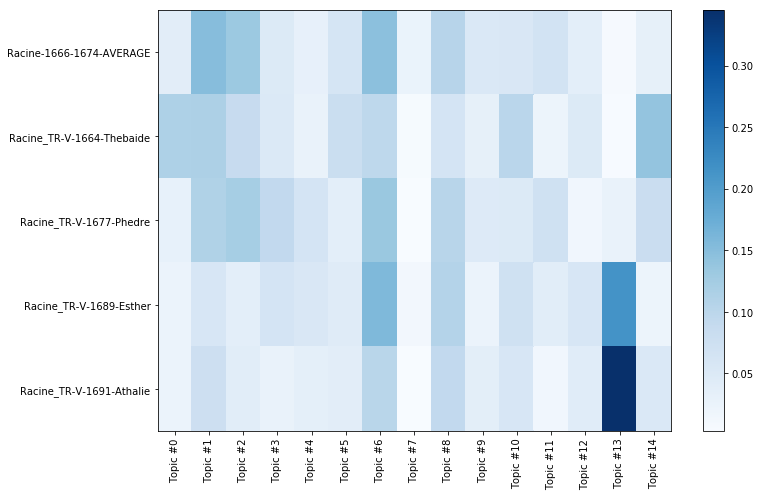

In [31]:

plt.figure(figsize=(11.3, 7))  # reset figure size

plt.pcolor(doctopic_of_interest, norm=None, cmap='Blues')

topic_labels = ['Topic #{}'.format(k) for k in range(num_topics)]
plt.xticks(np.arange(doctopic_of_interest.shape[1]) + 0.5, topic_labels);
plt.yticks(np.arange(doctopic_of_interest.shape[0]) + 0.5, play_names_of_interest);

# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')

plt.savefig('plots/9_racine_doctopic_heatmap.png', bbox_inches='tight')
plt.tight_layout()  # fixes margins
plt.show()



Looking at this heatmap, a number of topics stand out as ones which we might
wish to examine. In this case there is no harm in visually identifying the
topics that vary the most (using our eyes).  However, were we
confronted with a greater number of topics (say, 100 or 200 topics), such
a procedure would be tedious and error prone. We may as well come up with
a systematic way of identifying topics that vary substantially across texts of
interest. One way of doing this would be to calculate the standard deviation of
the document-topic shares across the topics. (Calculating the `entropy
<https://en.wikipedia.org/wiki/Entropy>`_ for topic-document associations would
also be a useful measure.)



In [35]:
# examine topics of interest by ranking them by standard deviation
# reminder: NumPy's standard deviation differs from R's standard deviation. If you
# want them to return identical results include the argument ``ddof=1``.
# Essentially,  NumPy's standard deviation divides the variance by ``n`` whereas R
# uses ``n-1`` (which is preferable as it gives an unbiased estimate of the variance).
# Using ``ddof=1`` makes NumPy use ``n-1``.
topics_by_std = np.argsort(np.std(doctopic_of_interest, axis=0, ddof=1))[::-1]
topics_by_std[0:10]

# First we gather the words most associated with each topic
num_top_words = 17
topic_words = []
print( len(clf.components_[0]) == len(vocab))
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

# Now we examine the topic-word distributions for the topics that vary the most
for t in topics_by_std[0:5]:
    topic_words_str = ' '.join(str(t) for t in topic_words[t])
    print("Topic {}: {}".format(t, topic_words_str))



True
Topic 13: dieu le et temple un qui la david séide est mahomet du chrétiens des sur enfant ce
Topic 14: fils le mon est de père ce sang dieux frère votre en son mère je crime ciel
Topic 2: je me que mon ai ma suis ne mes et puis moi veux sais vois dois tout
Topic 0: et un en pour si que la le qu de qui plus faire autre amour ou une
Topic 1: vous votre vos seigneur avez que de madame ne si êtes voulez pas le allez qui point


As our ranking indicates, most of the mystery about the atypical plays is
resolved by inspecting topics #5 and #9. (Only *PhÃ¨dre* (1677) needs 
additional scrutiny.) Given what we know about Racine's biography, topic #5
(dieu, temple, chrÃ©tiens) does not require a great deal of additional
explanation. Topic #9 is more strongly associated with *ThÃ©baÃ¯de* (1664) than
with any other play. Inspecting the words associated with topic #9 we see it
features words such as "et" and "un". If we read the text of the play it
appears that these words do indeed appear comparatively frequently. While we
will leave it to Racine scholars to provide a detailed account of the
difference, we may venture two provisional explanations: first, this was
Racine's first play and his style had yet to mature, and second, there is strong
evidence that MoliÃ¨re contributed to the editing of the play and this fact may
have something to do with the stylistic difference.

To verify that the Topic #9 does indeed capture a salient difference, we may
compare the rates of the words "et" and "un" across all Racine
plays. The rate of "et" in *ThÃ©baÃ¯de* does indeed stand out:


In [37]:
# reassemble the document-term matrix
data_dir = 'data/french-tragedy/'
filenames = np.array(sorted(os.listdir(data_dir)))
filenames_with_path = [os.path.join(data_dir, fn) for fn in filenames]
vectorizer = text.CountVectorizer(input='filename')
dtm = vectorizer.fit_transform(filenames_with_path)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())
authors = np.array([fn.split('_')[0] for fn in filenames])

# convert to rates per 1000 words as this is easier to interpret
dtm = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)


In [39]:

for word in ['et', 'un']:
    print("Rate per 1,000 words of {}".format(word))
    filenames_racine = filenames[authors == 'Racine']
    rates_racine = dtm[authors == 'Racine', vocab == word]
    for filename, rate in zip(filenames_racine, rates_racine):
        # use some fancy formatting, see http://docs.python.org/3.3/library/string.html#formatspec
        print("{:>40s}: {:.1f}".format(filename, rate))

Rate per 1,000 words of et
           Racine_TR-V-1664-Thebaide.txt: 32.8
          Racine_TR-V-1666-Alexandre.txt: 24.1
         Racine_TR-V-1668-Andromaque.txt: 22.8
        Racine_TR-V-1670-Britannicus.txt: 20.5
           Racine_TR-V-1671-Berenice.txt: 21.3
            Racine_TR-V-1672-Bajazet.txt: 24.9
         Racine_TR-V-1673-Mithridate.txt: 29.2
          Racine_TR-V-1674-Iphigenie.txt: 26.9
             Racine_TR-V-1677-Phedre.txt: 23.1
             Racine_TR-V-1689-Esther.txt: 24.6
            Racine_TR-V-1691-Athalie.txt: 25.7
Rate per 1,000 words of un
           Racine_TR-V-1664-Thebaide.txt: 13.2
          Racine_TR-V-1666-Alexandre.txt: 15.2
         Racine_TR-V-1668-Andromaque.txt: 13.7
        Racine_TR-V-1670-Britannicus.txt: 10.9
           Racine_TR-V-1671-Berenice.txt: 11.4
            Racine_TR-V-1672-Bajazet.txt: 12.2
         Racine_TR-V-1673-Mithridate.txt: 15.6
          Racine_TR-V-1674-Iphigenie.txt: 13.8
             Racine_TR-V-1677-Phedre.txt: 17.3
      

In addition to the Christian vocabulary associated with topic #5, *Esther* and
*Athalie* also distinguish themselves through an *absence* of topic #10. Looking
at the words associated with these topics a pattern emerges: the words are
associated with narration or dialogue. Topic #10 includes the first person
singular pronouns "je" and "me" along with the first person singular forms of
the verbs "Ãªtre" and "pouvoir" ("suis" and "puis"). Do Racine's final plays
perhaps feature dialogue to a lesser degree than Racine's other plays?

Again, to validate the suspicion that the words "je" and "me" do indeed appear
more frequently in the final plays we will look directly at their word rates.
The low rates of "je" and "me" in the final two plays certainly do stand out.



In [41]:
for word in ['je', 'me']:
    print("Rate per 1,000 words of {}".format(word))
    filenames_racine = filenames[authors == 'Racine']
    rates_racine = dtm[authors == 'Racine', vocab == word]
    for filename, rate in zip(filenames_racine, rates_racine):
        # use some fancy formatting, see http://docs.python.org/3.3/library/string.html#formatspec
        print("{:>40s}: {:.1f}".format(filename, rate))
    print()  # print a blank line


Rate per 1,000 words of je
           Racine_TR-V-1664-Thebaide.txt: 19.6
          Racine_TR-V-1666-Alexandre.txt: 18.4
         Racine_TR-V-1668-Andromaque.txt: 28.8
        Racine_TR-V-1670-Britannicus.txt: 22.4
           Racine_TR-V-1671-Berenice.txt: 31.8
            Racine_TR-V-1672-Bajazet.txt: 25.8
         Racine_TR-V-1673-Mithridate.txt: 26.0
          Racine_TR-V-1674-Iphigenie.txt: 21.7
             Racine_TR-V-1677-Phedre.txt: 24.3
             Racine_TR-V-1689-Esther.txt: 11.1
            Racine_TR-V-1691-Athalie.txt: 12.6

Rate per 1,000 words of me
           Racine_TR-V-1664-Thebaide.txt: 7.0
          Racine_TR-V-1666-Alexandre.txt: 7.0
         Racine_TR-V-1668-Andromaque.txt: 9.6
        Racine_TR-V-1670-Britannicus.txt: 8.0
           Racine_TR-V-1671-Berenice.txt: 10.9
            Racine_TR-V-1672-Bajazet.txt: 8.8
         Racine_TR-V-1673-Mithridate.txt: 10.3
          Racine_TR-V-1674-Iphigenie.txt: 8.9
             Racine_TR-V-1677-Phedre.txt: 8.2
            

Finally, we turn back to *PhÃ¨dre* (1677).  In terms of topic proportions,
*PhÃ¨dre* (1677) looks similar to the composite "average" Racine play. Inspecting
the dendrogram and the multidimensional scaling plot, we observe that the play
is, in fact, not so different from Racine's other plays; it stands out not
because it is as atypical as those discussed above but because it happens to be
similar (in terms of cosine distance) to several of Voltaire's plays.
Investigating why the works of a radical Enlightenment figure like Voltaire
should so strongly resemble Racine's is left as an exercise for the reader.

#### FOOTNOTES

.. [#fn_authors] This tutorial was written by `Allen Riddell <http://ariddell.org>`_.
   and `Christof SchÃ¶ch <http://www.christof-schoech.de>`_.


.. [#fn_authorship_attribution] Such signatures do not always appear.
   They can be eliminated with some modest effort on the part of the writer
   :cite:`brennan_adversarial_2011`. There are also many instances of writers
   changing their style over time---Henry James is an excellent example
   :cite:`hoover_corpus_2007`.)